# AON and ACTION Masking

Master Thesis: **Modulation of the Action Observation Network - Investigating Action, Actor and Observer Factors in an fMRI Study**

Author: Olaf Borghi olafborghi@gmail.com

Based on 
- https://lukas-snoek.com/NI-edu/fMRI-introduction/week_7/nilearn.html#region-extraction
- https://github.com/lrsktr/tewa-neuroimaging/blob/main/08_masking-and-extracting-signals/08_masking-extracting-signals.ipynb

## Prepare Setup

### Define fixed parameters, load libraries/modules

**Load modules**

In [1]:
# Import necessary packages and modules
%matplotlib inline
# libraries
import os
import numpy as np
import nibabel as nib
import pandas as pd
import nilearn as nl
from matplotlib import pyplot as plt
# specific modules
from nipype.interfaces import fsl
from nilearn import plotting, datasets, image
from nilearn.image import math_img
from nilearn.maskers import MultiNiftiMasker
from pathlib import Path
from pprint import pprint
from glob import glob
print(nl.__version__)

0.9.2


**Set fixed parameters**

In [86]:
# fixed folders
basedir = Path("/home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION")
outputdir = Path(basedir / "derivatives")
datadir = Path(basedir / "01_data")
first_level_dir = first_level_dir = outputdir / "first_level"
action_first_level_dir = first_level_dir / "action-task"
AON_first_level_dir = first_level_dir / "AON-task"
masks_templates_dir = outputdir / "masks_templates"
second_level_dir = outputdir / "second_level"
AON_second_level_dir = second_level_dir / "AON-task"
action_second_level_dir = second_level_dir / "action-task"

# make folder to store the brain atlases
if not os.path.exists(outputdir / "brain_atlases"):
    os.makedirs(outputdir / "brain_atlases")
atlas_dir = outputdir / "brain_atlases"


# make folder to store the ROI masks
if not os.path.exists(masks_templates_dir / "ROI_masks"):
    os.makedirs(masks_templates_dir / "ROI_masks")
roi_dir = masks_templates_dir / "ROI_masks"

In [3]:
# load the MNI template
template = datasets.load_mni152_template(resolution=1)

# store the MNI template also locally
mni_image_path = f"{masks_templates_dir}/mni_template_1mm.nii.gz"
template.to_filename(mni_image_path)

## load the brain atlases 

# harvard-oxford
ho_atlas = datasets.fetch_atlas_harvard_oxford("cortl-maxprob-thr0-1mm", data_dir=atlas_dir, symmetric_split=False)
print(f"The Harvard-Oxford atlas includes {len(ho_atlas.labels) - 1} regions")
print(f"Shape of the  Harvard-Oxford atlas: {ho_atlas.maps.shape}")
print(f"The Harvard-Oxford atlas image is located at: {ho_atlas.filename}")

# juelich brain atlas
ju_atlas = datasets.fetch_atlas_juelich("maxprob-thr0-1mm", data_dir=atlas_dir, symmetric_split=True)
print(f"The Juelich atlas includes {len(ju_atlas.labels) - 1} regions")
print(f"Shape of the  Juelich atlas: {ju_atlas.maps.shape}")
print(f"The Juelich atlas image is located at: {ju_atlas.filename}")

The Harvard-Oxford atlas includes 96 regions
Shape of the  Harvard-Oxford atlas: (182, 218, 182)
The Harvard-Oxford atlas image is located at: /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/brain_atlases/fsl/data/atlases/HarvardOxford/HarvardOxford-cortl-maxprob-thr0-1mm.nii.gz
The Juelich atlas includes 124 regions
Shape of the  Juelich atlas: (182, 218, 182)
The Juelich atlas image is located at: /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/brain_atlases/fsl/data/atlases/Juelich/Juelich-maxprob-thr0-1mm.nii.gz


In [4]:
# print the regions of the harvard oxford atlas
print("Harvard-Oxford Brain Atlas Regions:")
pprint(ho_atlas.labels)

# print the regions of the juelich brain atlas
print("Juelich Brain Atlas Regions:")
pprint(ju_atlas.labels)

Harvard-Oxford Brain Atlas Regions:
['Background',
 'Left Frontal Pole',
 'Right Frontal Pole',
 'Left Insular Cortex',
 'Right Insular Cortex',
 'Left Superior Frontal Gyrus',
 'Right Superior Frontal Gyrus',
 'Left Middle Frontal Gyrus',
 'Right Middle Frontal Gyrus',
 'Left Inferior Frontal Gyrus, pars triangularis',
 'Right Inferior Frontal Gyrus, pars triangularis',
 'Left Inferior Frontal Gyrus, pars opercularis',
 'Right Inferior Frontal Gyrus, pars opercularis',
 'Left Precentral Gyrus',
 'Right Precentral Gyrus',
 'Left Temporal Pole',
 'Right Temporal Pole',
 'Left Superior Temporal Gyrus, anterior division',
 'Right Superior Temporal Gyrus, anterior division',
 'Left Superior Temporal Gyrus, posterior division',
 'Right Superior Temporal Gyrus, posterior division',
 'Left Middle Temporal Gyrus, anterior division',
 'Right Middle Temporal Gyrus, anterior division',
 'Left Middle Temporal Gyrus, posterior division',
 'Right Middle Temporal Gyrus, posterior division',
 'Left Mi

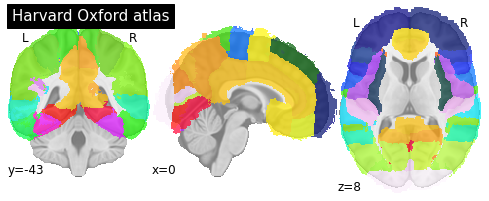

In [7]:
# plot the harvard-oxford atlas
plotting.plot_roi(ho_atlas.maps, title="Harvard Oxford atlas", draw_cross=False, bg_img=template, black_bg=False)

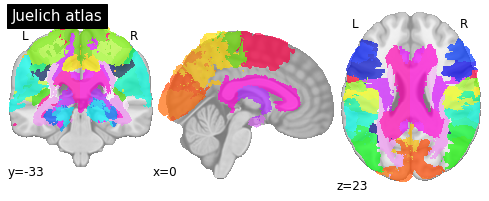

In [9]:
# plot the juelich brain atlas
plotting.plot_roi(ju_atlas.maps, title="Juelich atlas", draw_cross=False, bg_img=template, black_bg=False)

Let's try out some manipulations to get familiar with handling atlases!

In [86]:
ho_maxprob_atlas_img = image.load_img(ho_atlas['maps'])
print("ho_maxprob_atlas_img is a 3D image with shape %s" % (ho_maxprob_atlas_img.shape,))

ho_maxprob_atlas_img is a 3D image with shape (182, 218, 182)


In [69]:
region_int_labels = np.unique(ho_maxprob_atlas_img.get_fdata())
n_regions = region_int_labels.size

print("There are %i different regions in the Harvard-Oxford cortical atlas!" % n_regions)

There are 97 different regions in the Harvard-Oxford cortical atlas!


In [97]:
region_int_labels

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96.])

In [71]:
idx = 2
region_with_value2 = ho_atlas['labels'][idx]
print("The region with value 2 is: %s" % region_with_value2)

The region with value 2 is: Right Frontal Pole


### Select the Regions of Interest

I am interested in the typical Action Observation Network, a network of brain areas that usually includes the
- Inferior parietal lobule (IPL) --> Juelich Brain Atlas
- Inferior frontal gyrus (IFG) --> Harvard-Oxford Atlas
- Premotor cortex (PM) --> Juelich Brain Atlas
- Primary motor cortex (M1) --> Juelich Brain Atlas (also includes SMA)

To get the anatomical regions, I will use deterministic versions of the Harvard-Oxford and the Juelich Brain atlasses. 

First, I created a function to extract multiple sub-brain-regions from each atlas, in order to then create a binary mask of the whole region.


In [76]:
def MyNonProbMasker(atlas, regions):
    
    '''A quick function to extract multiple brain regions from a 
    non probabilistic 3D atlas in Nilearn. 
    
    Inputs: 
    Atlas = A brain atlas with keys for the 3D nifty image and the region labels
    Regions = A list of strings with the region names as defined by atlas.labels
    
    Returns: 
    mask_imgs = A dictionary, region : mask_img '''
            
    mask_imgs = {}
    
    for idx, roi in enumerate(regions):
        
        roi_idx  = atlas.labels.index(roi)
        
        print(roi_idx, " = ", atlas['labels'][roi_idx], " = ", roi)
        
        mask_img = image.new_img_like(atlas.maps, image.get_data(atlas.maps)==roi_idx)
        mask_imgs[roi]=mask_img
        plotting.plot_roi(mask_img, title=roi, draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")
        
    return mask_imgs

### Inferior parietal lobule (IPL)

For this region I use the non-probabilistic version of the Juelich brain atlas.

I start by creating to lists with the label names of the whole region that I am interested in.

In [24]:
left_ipl = ['Left GM Inferior parietal lobule PF L',
            'Left GM Inferior parietal lobule PFcm L',
            'Left GM Inferior parietal lobule PFm L',
            'Left GM Inferior parietal lobule PFop L',
            'Left GM Inferior parietal lobule PFt L',
            'Left GM Inferior parietal lobule Pga L',
            'Left GM Inferior parietal lobule PGp L']
            
right_ipl = ['Right GM Inferior parietal lobule PF R',
             'Right GM Inferior parietal lobule PFcm R',
             'Right GM Inferior parietal lobule PFm R',
             'Right GM Inferior parietal lobule PFop R',
             'Right GM Inferior parietal lobule PFt R',
             'Right GM Inferior parietal lobule Pga R',
             'Right GM Inferior parietal lobule PGp R']

I then compute an individual mask for each subpart of the left IPL in the Jülich brain atlas. 
To do so, I use the function that I created above. 

**Left IPL**

27  =  Left GM Inferior parietal lobule PF L  =  Left GM Inferior parietal lobule PF L
29  =  Left GM Inferior parietal lobule PFcm L  =  Left GM Inferior parietal lobule PFcm L
31  =  Left GM Inferior parietal lobule PFm L  =  Left GM Inferior parietal lobule PFm L
33  =  Left GM Inferior parietal lobule PFop L  =  Left GM Inferior parietal lobule PFop L
35  =  Left GM Inferior parietal lobule PFt L  =  Left GM Inferior parietal lobule PFt L
37  =  Left GM Inferior parietal lobule Pga L  =  Left GM Inferior parietal lobule Pga L
39  =  Left GM Inferior parietal lobule PGp L  =  Left GM Inferior parietal lobule PGp L


{'Left GM Inferior parietal lobule PF L': <nibabel.nifti1.Nifti1Image at 0x7ff64c3a2790>,
 'Left GM Inferior parietal lobule PFcm L': <nibabel.nifti1.Nifti1Image at 0x7ff651078910>,
 'Left GM Inferior parietal lobule PFm L': <nibabel.nifti1.Nifti1Image at 0x7ff64c17c6a0>,
 'Left GM Inferior parietal lobule PFop L': <nibabel.nifti1.Nifti1Image at 0x7ff596de29a0>,
 'Left GM Inferior parietal lobule PFt L': <nibabel.nifti1.Nifti1Image at 0x7ff596d1a5b0>,
 'Left GM Inferior parietal lobule Pga L': <nibabel.nifti1.Nifti1Image at 0x7ff596ca66a0>,
 'Left GM Inferior parietal lobule PGp L': <nibabel.nifti1.Nifti1Image at 0x7ff596bdbc40>}

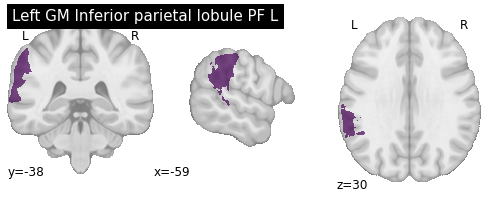

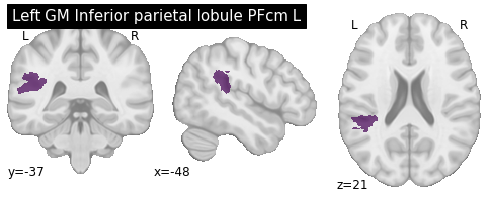

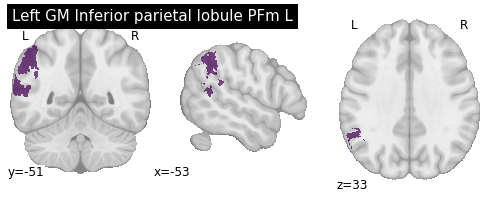

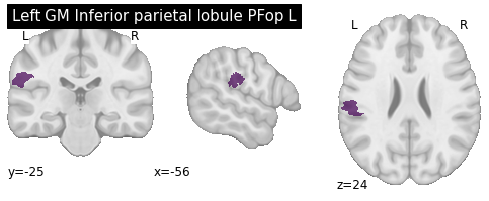

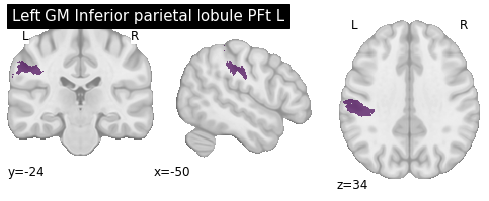

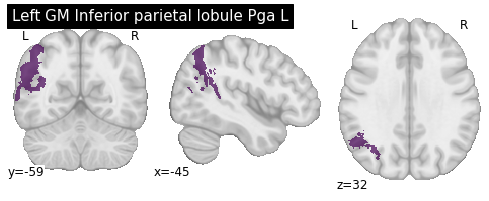

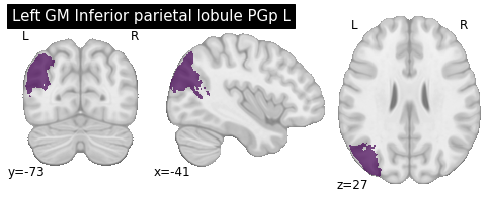

In [77]:
left_ipl_imgs = MyNonProbMasker(ju_atlas, left_ipl)
left_ipl_imgs

However, like this I end up with seven individual masks, but actually, I want a single mask for all of the left IPL. As the regions should not overlap and are all binary, I can use nilearn.math.img to sum them up. 

In [78]:
left_ipl_mask = image.math_img("img1 + img2 + img3 + img4 + img5 + img6 + img7", 
                               img1=left_ipl_imgs.get(left_ipl[0]), 
                               img2=left_ipl_imgs.get(left_ipl[1]), 
                               img3=left_ipl_imgs.get(left_ipl[2]), 
                               img4=left_ipl_imgs.get(left_ipl[3]), 
                               img5=left_ipl_imgs.get(left_ipl[4]), 
                               img6=left_ipl_imgs.get(left_ipl[5]), 
                               img7=left_ipl_imgs.get(left_ipl[6]))

Quick check whether we still have a binary image

In [79]:
lipl_int_labels = np.unique(left_ipl_mask.get_fdata())
n_regions = lipl_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {lipl_int_labels}")

There are 2 different regions in the left IPL mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


And finally plot our mask of the left IPL!

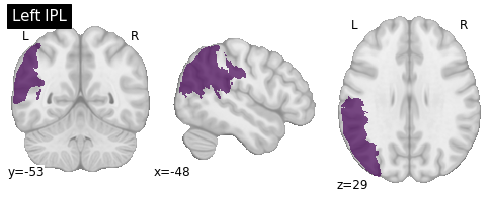

In [80]:
plotting.plot_roi(left_ipl_mask, title="Left IPL", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

Alright! That worked really well :) 

**Now let's do the same with the right IPL!**

28  =  Right GM Inferior parietal lobule PF R  =  Right GM Inferior parietal lobule PF R
30  =  Right GM Inferior parietal lobule PFcm R  =  Right GM Inferior parietal lobule PFcm R
32  =  Right GM Inferior parietal lobule PFm R  =  Right GM Inferior parietal lobule PFm R
34  =  Right GM Inferior parietal lobule PFop R  =  Right GM Inferior parietal lobule PFop R
36  =  Right GM Inferior parietal lobule PFt R  =  Right GM Inferior parietal lobule PFt R
38  =  Right GM Inferior parietal lobule Pga R  =  Right GM Inferior parietal lobule Pga R
40  =  Right GM Inferior parietal lobule PGp R  =  Right GM Inferior parietal lobule PGp R


{'Right GM Inferior parietal lobule PF R': <nibabel.nifti1.Nifti1Image at 0x7ff596dd9460>,
 'Right GM Inferior parietal lobule PFcm R': <nibabel.nifti1.Nifti1Image at 0x7ff596873f40>,
 'Right GM Inferior parietal lobule PFm R': <nibabel.nifti1.Nifti1Image at 0x7ff5d5fc17f0>,
 'Right GM Inferior parietal lobule PFop R': <nibabel.nifti1.Nifti1Image at 0x7ff596b65820>,
 'Right GM Inferior parietal lobule PFt R': <nibabel.nifti1.Nifti1Image at 0x7ff596d6ae80>,
 'Right GM Inferior parietal lobule Pga R': <nibabel.nifti1.Nifti1Image at 0x7ff5969427f0>,
 'Right GM Inferior parietal lobule PGp R': <nibabel.nifti1.Nifti1Image at 0x7ff596bfb2e0>}

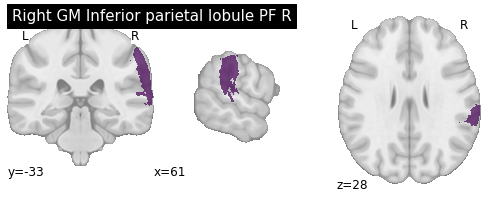

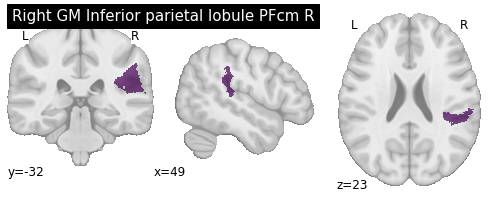

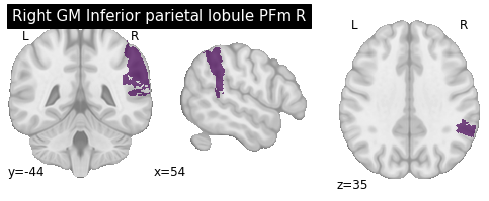

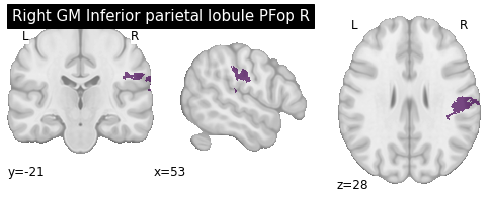

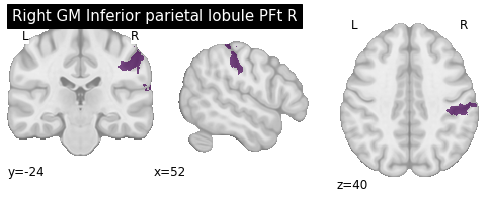

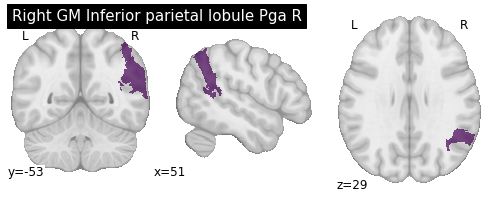

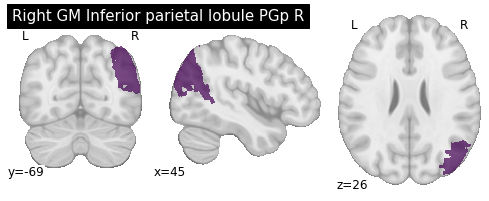

In [81]:
right_ipl_imgs = MyNonProbMasker(ju_atlas, right_ipl)
right_ipl_imgs

In [82]:
# sum up the binary masks of the subregions to get one larger mask
right_ipl_mask = image.math_img("img1 + img2 + img3 + img4 + img5 + img6 + img7", 
                                img1=right_ipl_imgs.get(right_ipl[0]), 
                                img2=right_ipl_imgs.get(right_ipl[1]), 
                                img3=right_ipl_imgs.get(right_ipl[2]), 
                                img4=right_ipl_imgs.get(right_ipl[3]), 
                                img5=right_ipl_imgs.get(right_ipl[4]), 
                                img6=right_ipl_imgs.get(right_ipl[5]), 
                                img7=right_ipl_imgs.get(right_ipl[6]))

In [83]:
# quick sanity check
ripl_int_labels = np.unique(right_ipl_mask.get_fdata())
n_regions = ripl_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {ripl_int_labels}")

There are 2 different regions in the right IPL mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


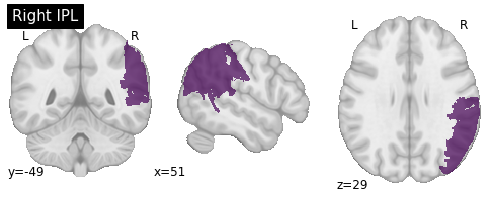

In [94]:
# plot the region
plotting.plot_roi(right_ipl_mask, title="Right IPL", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

Let's save the mask locally, so that I can re-use them at later times. 

In [88]:
# save the left ipl mask to path 
left_ipl_mask_path = f"{roi_dir}/left_inferior_parietal_lobule_mask.nii.gz"
left_ipl_mask.to_filename(left_ipl_mask_path)

# save the right ipl mask to path 
right_ipl_mask_path = f"{roi_dir}/right_inferior_parietal_lobule_mask.nii.gz"
right_ipl_mask.to_filename(right_ipl_mask_path)

### Inferior frontal gyrus (IFG)

For this area I will use the non-probabilistic version of the Harvard-Oxford brain atlas.

In [90]:
# store the labels of the regions in a list (separate for each hemisphere)

left_ifg = ['Left Inferior Frontal Gyrus, pars triangularis',
            'Left Inferior Frontal Gyrus, pars opercularis']

right_ifg = ['Right Inferior Frontal Gyrus, pars triangularis',
             'Right Inferior Frontal Gyrus, pars opercularis']

**Left IFG**

9  =  Left Inferior Frontal Gyrus, pars triangularis  =  Left Inferior Frontal Gyrus, pars triangularis
11  =  Left Inferior Frontal Gyrus, pars opercularis  =  Left Inferior Frontal Gyrus, pars opercularis


{'Left Inferior Frontal Gyrus, pars triangularis': <nibabel.nifti1.Nifti1Image at 0x7ff651059970>,
 'Left Inferior Frontal Gyrus, pars opercularis': <nibabel.nifti1.Nifti1Image at 0x7ff64c4a3eb0>}

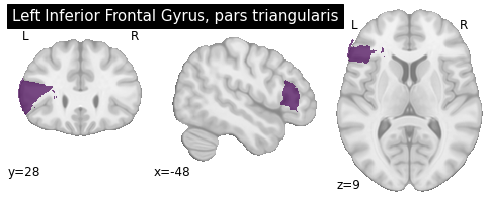

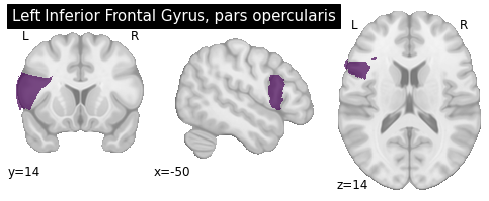

In [91]:
# use the function to compute the individual masks of each sub-region
left_ifg_imgs = MyNonProbMasker(ho_atlas, left_ifg)
left_ifg_imgs

In [92]:
# sum up the sub regions of the IFG for a mask of the whole right IFG
left_ifg_mask = image.math_img("img1 + img2", 
                                img1=left_ifg_imgs.get(left_ifg[0]), 
                                img2=left_ifg_imgs.get(left_ifg[1]))

In [93]:
# quick sanity check
lifg_int_labels = np.unique(left_ifg_mask.get_fdata())
n_regions = lifg_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {lifg_int_labels}")

There are 2 different regions in the right IPL mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


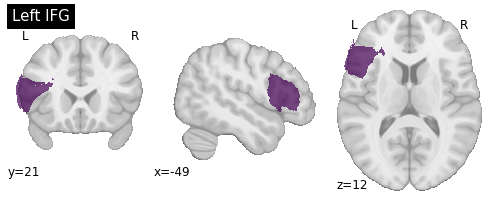

In [95]:
# plot the region
plotting.plot_roi(left_ifg_mask, title="Left IFG", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

**Right IFG**

10  =  Right Inferior Frontal Gyrus, pars triangularis  =  Right Inferior Frontal Gyrus, pars triangularis
12  =  Right Inferior Frontal Gyrus, pars opercularis  =  Right Inferior Frontal Gyrus, pars opercularis


{'Right Inferior Frontal Gyrus, pars triangularis': <nibabel.nifti1.Nifti1Image at 0x7ff596b446a0>,
 'Right Inferior Frontal Gyrus, pars opercularis': <nibabel.nifti1.Nifti1Image at 0x7ff596a8f130>}

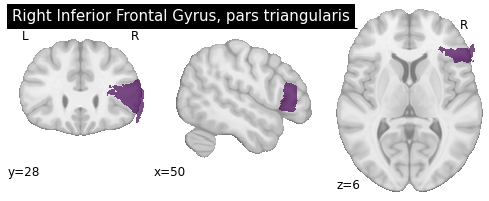

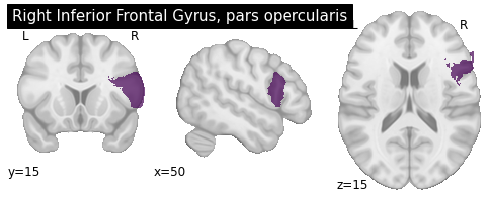

In [96]:
# use the function to compute the individual masks of each sub-region
right_ifg_imgs = MyNonProbMasker(ho_atlas, right_ifg)
right_ifg_imgs

In [97]:
# sum up the sub regions of the IFG for a mask of the whole right IFG
right_ifg_mask = image.math_img("img1 + img2", 
                                img1=right_ifg_imgs.get(right_ifg[0]), 
                                img2=right_ifg_imgs.get(right_ifg[1]))

In [116]:
# quick sanity check
rifg_int_labels = np.unique(right_ifg_mask.get_fdata())
n_regions = rifg_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {rifg_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


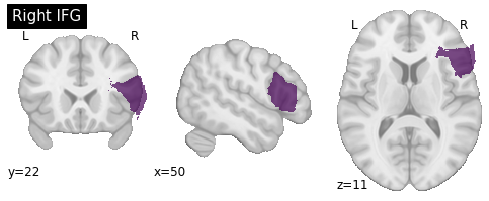

In [99]:
# plot the region
plotting.plot_roi(right_ifg_mask, title="Right IFG", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

Save both IFG masks locally

In [100]:
# save the left ifg mask to path 
left_ifg_mask_path = f"{roi_dir}/left_inferior_frontal_gyrus_mask.nii.gz"
left_ifg_mask.to_filename(left_ifg_mask_path)

# save the right ifg mask to path 
right_ifg_mask_path = f"{roi_dir}/right_inferior_frontal_gyrus_mask.nii.gz"
right_ifg_mask.to_filename(right_ifg_mask_path)

### Premotor cortex (PM)

For this area I will use the non-probabilistic version of the Juelich brain atlas.

In [144]:
# store the labels of the regions in a list (separate for each hemisphere)
left_pm = ['Left GM Premotor cortex BA6 L']
right_pm = [ 'Right GM Premotor cortex BA6 R']

**Left PM**

91  =  Left GM Premotor cortex BA6 L  =  Left GM Premotor cortex BA6 L


{'Left GM Premotor cortex BA6 L': <nibabel.nifti1.Nifti1Image at 0x7ff593e4c700>}

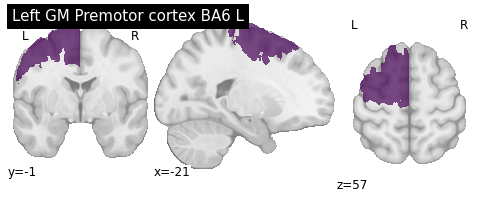

In [145]:
# use the function to binarize the individual masks of the region
left_pm_img = MyNonProbMasker(ju_atlas, left_pm)
left_pm_img

**Right PM**

92  =  Right GM Premotor cortex BA6 R  =  Right GM Premotor cortex BA6 R


{'Right GM Premotor cortex BA6 R': <nibabel.nifti1.Nifti1Image at 0x7ff593e60d90>}

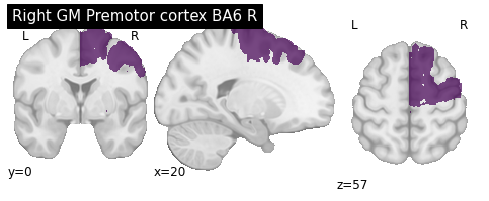

In [147]:
# use the function to compute the individual masks of each sub-region
right_pm_img = MyNonProbMasker(ju_atlas, right_pm)
right_pm_img

Save both PM masks locally

In [148]:
# save the left pm mask to path 
left_pm_mask = left_pm_img.get(left_pm[0])
left_pm_mask_path = f"{roi_dir}/left_premotor_cortex_mask.nii.gz"
left_pm_mask.to_filename(left_pm_mask_path)

# save the right pm mask to path 
right_pm_mask = right_pm_img.get(right_pm[0])
right_pm_mask_path = f"{roi_dir}/right_premotor_cortex_mask.nii.gz"
right_pm_mask.to_filename(right_pm_mask_path)

### Primary Motor Area (M1)

For this area I will use the non-probabilistic version of the Juelich brain atlas.

In [149]:
# store the labels of the regions in a list (separate for each hemisphere)

left_m1 = ['Left GM Primary motor cortex BA4a L',
           'Left GM Primary motor cortex BA4p L',]

right_m1 = ['Right GM Primary motor cortex BA4a R',
            'Right GM Primary motor cortex BA4p R',]

**Left M1**

47  =  Left GM Primary motor cortex BA4a L  =  Left GM Primary motor cortex BA4a L
49  =  Left GM Primary motor cortex BA4p L  =  Left GM Primary motor cortex BA4p L


{'Left GM Primary motor cortex BA4a L': <nibabel.nifti1.Nifti1Image at 0x7ff5938220a0>,
 'Left GM Primary motor cortex BA4p L': <nibabel.nifti1.Nifti1Image at 0x7ff594046220>}

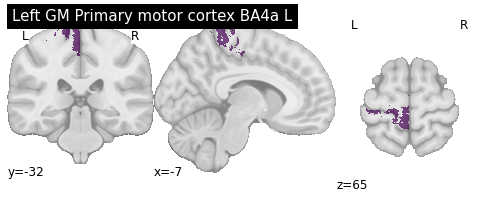

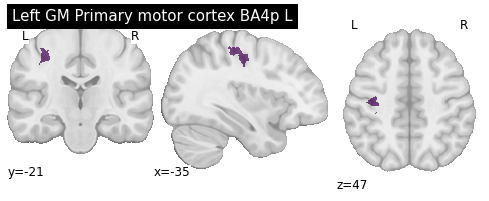

In [150]:
# use the function to compute the individual masks of each sub-region
left_m1_imgs = MyNonProbMasker(ju_atlas, left_m1)
left_m1_imgs

In [151]:
# sum up the sub regions of the lM1 
left_m1_mask = image.math_img("img1 + img2", 
                              img1=left_pm_imgs.get(left_m1[0]), 
                              img2=left_pm_imgs.get(left_m1[1]))

In [152]:
# quick sanity check
lm1_int_labels = np.unique(left_m1_mask.get_fdata())
n_regions = lm1_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {lm1_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


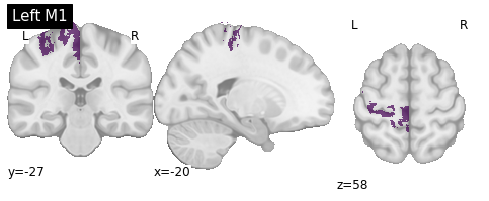

In [153]:
# plot the region
plotting.plot_roi(left_m1_mask, title="Left M1", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

**Right M1**

48  =  Right GM Primary motor cortex BA4a R  =  Right GM Primary motor cortex BA4a R
50  =  Right GM Primary motor cortex BA4p R  =  Right GM Primary motor cortex BA4p R


{'Right GM Primary motor cortex BA4a R': <nibabel.nifti1.Nifti1Image at 0x7ff59464ee80>,
 'Right GM Primary motor cortex BA4p R': <nibabel.nifti1.Nifti1Image at 0x7ff593790b20>}

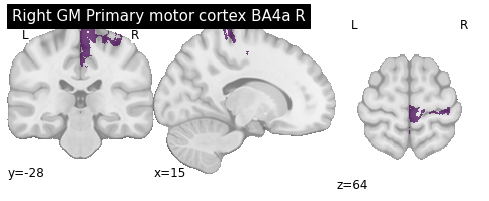

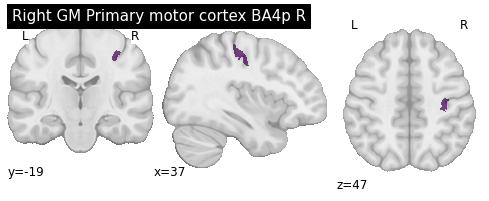

In [154]:
# use the function to compute the individual masks of each sub-region
right_m1_imgs = MyNonProbMasker(ju_atlas, right_m1)
right_m1_imgs

In [155]:
# sum up the sub regions of the rM1 
right_m1_mask = image.math_img("img1 + img2", 
                                img1=right_m1_imgs.get(right_m1[0]), 
                                img2=right_m1_imgs.get(right_m1[1]))

In [156]:
# quick sanity check
rm1_int_labels = np.unique(right_m1_mask.get_fdata())
n_regions = rm1_int_labels.size

print(f"There are {n_regions} different regions in the  mask! Check here if the mask is binary (should be 0 and 1): {rm1_int_labels}")

There are 2 different regions in the  mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


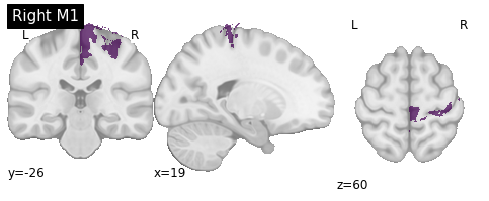

In [157]:
# plot the region
plotting.plot_roi(right_m1_mask, title="Right M1", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

Save both M1 masks locally

In [158]:
# save the left m1 mask to path 
left_m1_mask_path = f"{roi_dir}/left_primary_motor_cortex_mask.nii.gz"
left_m1_mask.to_filename(left_m1_mask_path)

# save the right m1 mask to path 
right_m1_mask_path = f"{roi_dir}/right_primary_motor_cortex_mask.nii.gz"
right_m1_mask.to_filename(right_m1_mask_path)

## Sanity Checks

We have our total of 10 masks now, let's check, if they are all ok!

- Inferior parietal lobule (IPL) --> Juelich Brain Atlas --> left_ipl_mask & right_ipl_mask
- Inferior frontal gyrus (IFG) --> Harvard-Oxford Atlas -->  left_ifg_mask & right_ifg_mask
- Premotor cortex (PM) --> Juelich Brain Atlas --> left_pm_mask & right_pm_mask
- Primary motor cortex (M1) --> Juelich Brain Atlas --> left_m1_mask & right_m1_mask

In [166]:
# lets store all masks in a list
all_masks = [left_ipl_mask, right_ipl_mask,
             left_ifg_mask, right_ifg_mask,
             left_pm_mask, right_pm_mask,
             left_m1_mask, right_m1_mask]

(182, 218, 182)
(182, 218, 182)
(182, 218, 182)
(182, 218, 182)
(182, 218, 182)
(182, 218, 182)
(182, 218, 182)
(182, 218, 182)


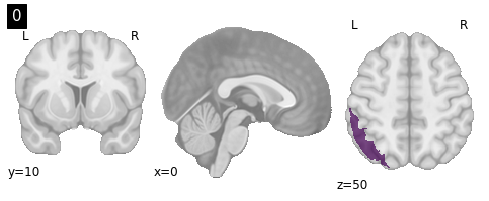

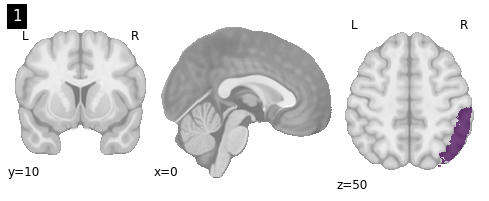

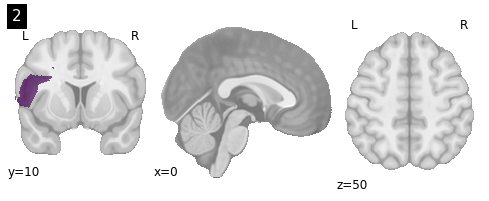

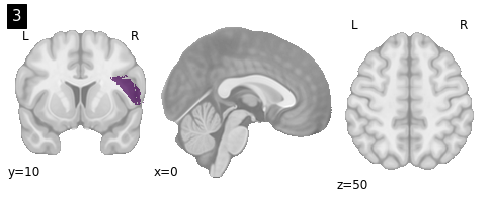

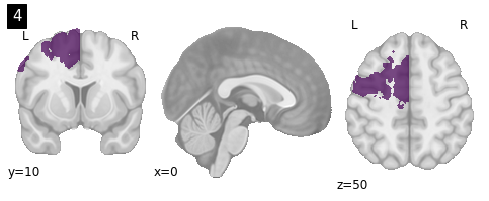

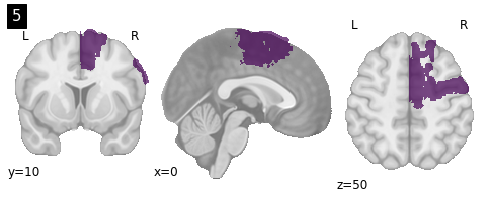

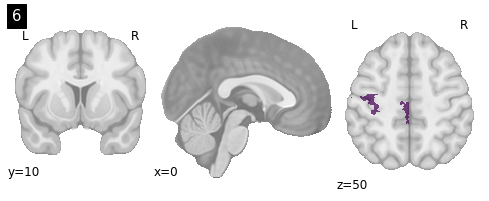

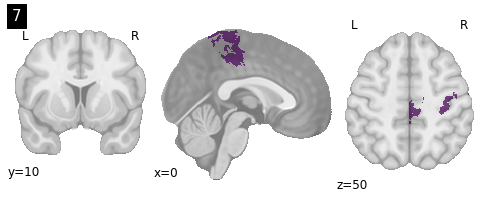

In [171]:
# plot them all
for idx, mask in enumerate(all_masks):
    plotting.plot_roi(mask, title=idx, draw_cross=False, bg_img=template, black_bg=False, cmap="viridis", cut_coords=(0,10,50))

In [181]:
# lets sum up all of our anatomical ROIs to check if they overlap
anat_roi_mask = image.math_img("img1 + img2 + img3 + img4 + img5 + img6 + img7 + img8", 
                           img1 = left_ipl_mask,
                           img2 = right_ipl_mask,
                           img3 = left_ifg_mask,
                           img4 = right_ifg_mask,
                           img5 = left_pm_mask,
                           img6 = right_pm_mask,
                           img7 = left_m1_mask,
                           img8 = right_m1_mask)

In [182]:
# quick sanity check
anat_roi_mask_int_labels = np.unique(anat_roi_mask.get_fdata())
n_regions = anat_roi_mask_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {anat_roi_mask_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


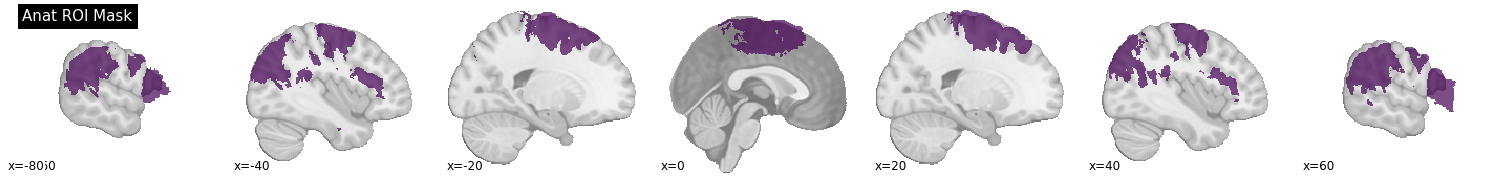

In [183]:
# plot the region
plotting.plot_roi(anat_roi_mask, title="Anat ROI Mask", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis", display_mode = 'x', cut_coords=np.arange(-80,80,20))

Looks great! Now we are ready to combine each mask with the AON_ACTION conjunction mask we created in the second level model, to get our final masks to extract the signal.

## Combine individual regions with conjunction mask to get final masks

In [190]:
conjunction_mask = f"{masks_templates_dir}/conjunction_mask.nii.gz"
conjunction_mask = nib.load(conjunction_mask)

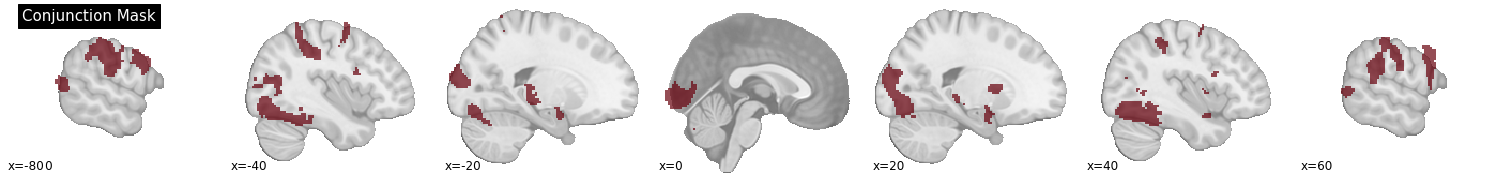

In [185]:
plotting.plot_roi(conjunction_mask, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Conjunction Mask", bg_img = template, cmap="Reds_r", black_bg = False)

/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


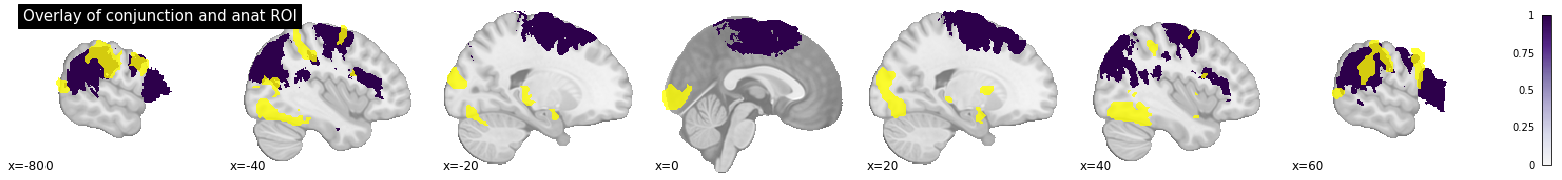

In [186]:
# Visually overlay the conjunction map with our a-priori ROI map
anat_roi_plot = plotting.plot_stat_map(anat_roi_mask, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Overlay of conjunction and anat ROI", bg_img = template, cmap="PuOr", black_bg = False)
anat_roi_plot.add_contours(conjunction_mask, filled=True, alpha=0.8, colors="yellow")

In [198]:
print("Shape of conjunction mask:", np.shape(conjunction_mask))
print("Affine of conjunction mask:")
print(conjunction_mask.affine)
print("Shape of anat_roi mask:", np.shape(anat_roi_mask))
print("Affine of anat_roi_mask:")
print(anat_roi_mask.affine)

Shape of conjunction mask: (91, 109, 91)
Affine of conjunction mask:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
Shape of anat_roi mask: (182, 218, 182)
Affine of anat_roi_mask:
[[   1.    0.    0.  -91.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]


So although are masks are aligned, they do not have the same shape and affine. Let's take care of this.

In [202]:
anat_roi_resamp = image.resample_img(
    anat_roi_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3]
)

print("New shape of anat_roi mask:", np.shape(anat_roi_resamp))
print("New affine of anat_roi mask:")
print(anat_roi_resamp.affine)

/usr/local/lib/python3.8/dist-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


New shape of anat_roi mask: (91, 109, 91)
New affine of anat_roi mask:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]


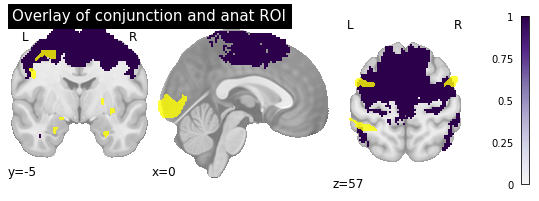

In [208]:
# Visually overlay the conjunction map with our resampled a-priori ROI map
anat_roi_resamp_plot = plotting.plot_stat_map(anat_roi_resamp, draw_cross=False,
                       title="Overlay of conjunction and anat ROI", bg_img = template, cmap="PuOr", black_bg = False)
anat_roi_resamp_plot.add_contours(conjunction_mask, filled=True, alpha=0.8, colors="yellow")

#### Bow combine each anatomical ROI with our conjunction mask in order to create to specific ROIs for data extraction from each region.

**Left Inferior Parietal Lobule * Conjunction**

In [210]:
# resample the left IPL mask
left_ipl_resamp = image.resample_img(
    left_ipl_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3]
)

/usr/local/lib/python3.8/dist-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


In [230]:
left_ipl_aon_mask = image.math_img("img1 * img2", 
                                   img1 = left_ipl_resamp,
                                   img2 = conjunction_mask)

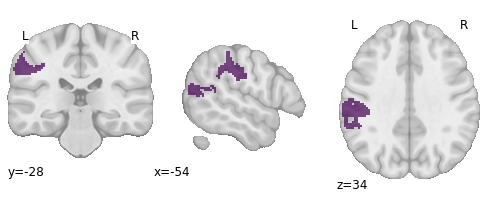

In [223]:
plotting.plot_roi(left_ipl_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [231]:
# save the mask to path 
left_ipl_aon_mask_path = f"{roi_dir}/left_ipl_aon_mask.nii.gz"
left_ipl_aon_mask.to_filename(left_ipl_aon_mask_path)

**Right IPL * Conjunction**

In [214]:
# resample the mask
right_ipl_resamp = image.resample_img(
    right_ipl_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3]
)

/usr/local/lib/python3.8/dist-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


In [215]:
right_ipl_aon_mask = image.math_img("img1 * img2", 
                                   img1 = right_ipl_resamp,
                                   img2 = conjunction_mask)

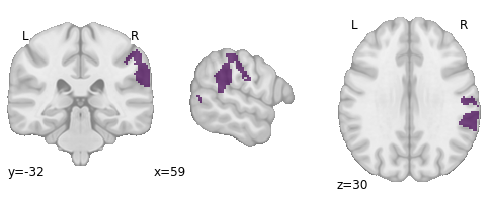

In [224]:
plotting.plot_roi(right_ipl_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [232]:
# save the mask to path 
right_ipl_aon_mask_path = f"{roi_dir}/right_ipl_aon_mask.nii.gz"
right_ipl_aon_mask.to_filename(right_ipl_aon_mask_path)

**Left IFG * Conjunction**

In [225]:
# resample the mask
left_ifg_resamp = image.resample_img(
    left_ifg_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3]
)

/usr/local/lib/python3.8/dist-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


In [226]:
left_ifg_aon_mask = image.math_img("img1 * img2", 
                                   img1 = left_ifg_resamp,
                                   img2 = conjunction_mask)

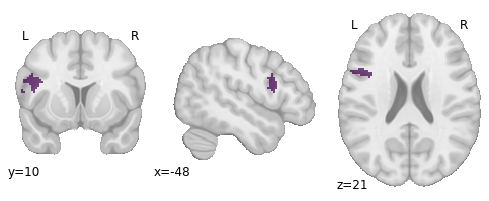

In [227]:
plotting.plot_roi(left_ifg_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [233]:
# save the mask to path 
left_ifg_aon_mask_path = f"{roi_dir}/left_ifg_aon_mask.nii.gz"
left_ifg_aon_mask.to_filename(left_ifg_aon_mask_path)

**Right IFG * Conjunction**

In [234]:
# resample the mask
right_ifg_resamp = image.resample_img(
    right_ifg_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3]
)

/usr/local/lib/python3.8/dist-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


In [235]:
right_ifg_aon_mask = image.math_img("img1 * img2", 
                                   img1 = right_ifg_resamp,
                                   img2 = conjunction_mask)

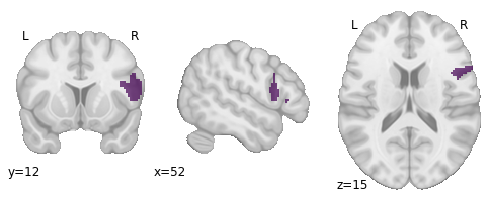

In [236]:
plotting.plot_roi(right_ifg_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [237]:
# save the mask to path 
right_ifg_aon_mask_path = f"{roi_dir}/right_ifg_aon_mask.nii.gz"
right_ifg_aon_mask.to_filename(right_ifg_aon_mask_path)

**Left premotor cortex * Conjunction**

In [245]:
# resample the mask
left_pm_resamp = image.resample_img(
    left_pm_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3]
)

/usr/local/lib/python3.8/dist-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


In [246]:
left_pm_aon_mask = image.math_img("img1 * img2", 
                                   img1 = left_pm_resamp,
                                   img2 = conjunction_mask)

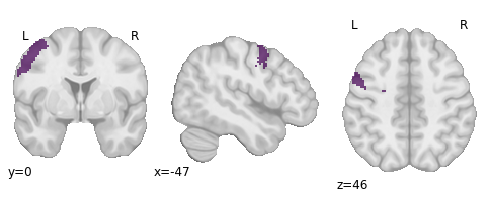

In [247]:
plotting.plot_roi(left_pm_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [248]:
# save the mask to path 
left_pm_aon_mask_path = f"{roi_dir}/left_pm_aon_mask.nii.gz"
left_pm_aon_mask.to_filename(left_pm_aon_mask_path)

**Right premotor cortex * Conjunction**

In [249]:
# resample the mask
right_pm_resamp = image.resample_img(
    right_pm_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3]
)

/usr/local/lib/python3.8/dist-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


In [250]:
right_pm_aon_mask = image.math_img("img1 * img2", 
                                   img1 = right_pm_resamp,
                                   img2 = conjunction_mask)

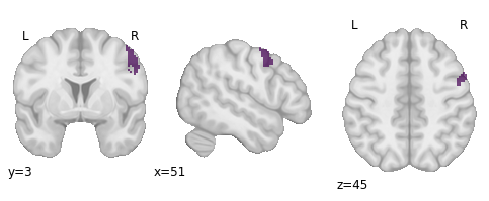

In [251]:
plotting.plot_roi(right_pm_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [252]:
# save the mask to path 
right_pm_aon_mask_path = f"{roi_dir}/right_pm_aon_mask.nii.gz"
right_pm_aon_mask.to_filename(right_pm_aon_mask_path)

**Left primary motor cortex (M1) * Conjunction**

In [238]:
# resample the mask
left_m1_resamp = image.resample_img(
    left_m1_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3]
)

/usr/local/lib/python3.8/dist-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


In [239]:
left_m1_aon_mask = image.math_img("img1 * img2", 
                                   img1 = left_m1_resamp,
                                   img2 = conjunction_mask)

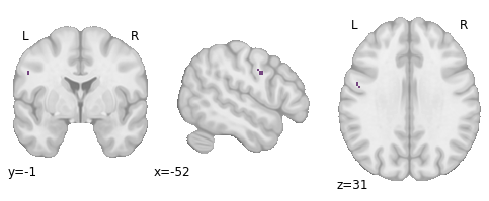

In [240]:
plotting.plot_roi(left_m1_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [241]:
# save the mask to path 
left_m1_aon_mask_path = f"{roi_dir}/left_m1_aon_mask.nii.gz"
left_m1_aon_mask.to_filename(left_m1_aon_mask_path)

**Right M1 * Conjunction**

In [242]:
# resample the mask
right_m1_resamp = image.resample_img(
    right_m1_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3]
)

/usr/local/lib/python3.8/dist-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


In [243]:
right_m1_aon_mask = image.math_img("img1 * img2", 
                                   img1 = right_m1_resamp,
                                   img2 = conjunction_mask)

/usr/local/lib/python3.8/dist-packages/nilearn/plotting/find_cuts.py:69: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


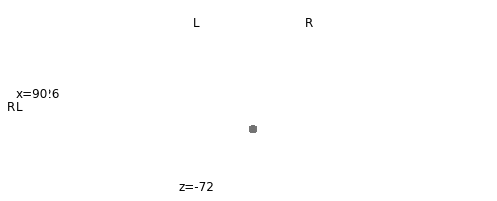

In [244]:
plotting.plot_roi(right_m1_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

#### Empty mask -- No overlap in the right primary motor cortex - this could be based on the fact that in the action task participants only moved their right hand (--> more activation in the left motor cortex)

# Thats it - we end up with the following masks that I will use in the next script extract_signal.ipynb to extract the signal from each region:
- Left IPL AON mask
- Right IPL AON mask
- Left IFG AON mask
- Right IFG AON mask
- Left PM AON mask
- Right PM AON mask
- Left M1 AON mask
 
No overlap was found in the right primary motor cortex.